In [22]:
# --------Overview----------------------------------------------------------------
# This notebook implements Grover's search algorithm and exposes it across multiple
# quantum frameworks (Cirq, Qiskit, PyQuil, PennyLane, AmazonBraket) via a lightweight
# translation layer ('quantumgateway'). The code defines oracles for specific 6-bit
# target strings, constructs Grover iterations (oracle + diffusion), executes the
# circuit on the chosen backend, and plots the resulting measurement distribution.

from quantumgateway.quantum_circuit import QuantumCircuit, QuantumGate
from quantumgateway.quantum_translator.braket_translator import BraketTranslator
from quantumgateway.quantum_translator.cirq_translator import CirqTranslator
from quantumgateway.quantum_translator.qiskit_translator import QiskitTranslator
from quantumgateway.quantum_translator.pennylane_translator import PennyLaneTranslator
from quantumgateway.quantum_translator.pyquil_translator import PyQuilTranslator
from quantumgateway.main import translate_to_framework, simulate_circuit
import numpy as np

n = 10  
circuit = QuantumCircuit(n, n)

def mcz_manual(circuit):
    
    circuit.add_gate(QuantumGate("toffoli", [0, 1, 6]))    
    circuit.add_gate(QuantumGate("toffoli", [2, 6, 7]))
    circuit.add_gate(QuantumGate("toffoli", [3, 7, 8]))
    circuit.add_gate(QuantumGate("toffoli", [4, 8, 9])) 
    circuit.add_gate(QuantumGate("cz", [9, 5]))
    # uncompute ancillas
    circuit.add_gate(QuantumGate("toffoli", [4, 8, 9]))
    circuit.add_gate(QuantumGate("toffoli", [3, 7, 8]))
    circuit.add_gate(QuantumGate("toffoli", [2, 6, 7]))
    circuit.add_gate(QuantumGate("toffoli", [0, 1, 6])) 

def superpos(circuit):
    for i in range(6):
        circuit.add_gate(QuantumGate("h", [i]))

def diffusion(circuit):
    for i in range(6):
        circuit.add_gate(QuantumGate("h", [i]))
        circuit.add_gate(QuantumGate("x", [i]))
    
    mcz_manual(circuit)
    
    for i in range(6):
        circuit.add_gate(QuantumGate("x", [i]))
        circuit.add_gate(QuantumGate("h", [i]))

In [23]:
oracles = {
    "000000": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in range(6)],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in range(6)]
    ),
    "000001": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in range(5)],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in range(5)]
    ),
    "000010": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,3,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,3,5]]
    ),
    "000011": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,3]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,3]]
    ),
    "000100": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,4,5]]
    ),
    "000101": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,4]]
    ),
    "000110": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2,5]]
    ),
    "000111": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,2]]
    ),
    "001000": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,3,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,3,4,5]]
    ),
    "001001": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,3,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,3,4]]
    ),
    "001010": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,3,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,3,5]]
    ),
    "001011": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,3]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,3]]
    ),
    "001100": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,4,5]]
    ),
    "001101": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,4]]
    ),
    "001110": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1,5]]
    ),
    "001111": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,1]]
    ),
    "010000": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,3,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,3,4,5]]
    ),
    "010001": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,3,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,3,4]]
    ),
    "010010": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,3,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,3,5]]
    ),
    "010011": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,3]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,3]]
    ),
    "010100": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,4,5]]
    ),
    "010101": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,4]]
    ),
    "010110": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2,5]]
    ),
    "010111": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,2]]
    ),
    "011000": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,3,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,3,4,5]]
    ),
    "011001": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,3,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,3,4]]
    ),
    "011010": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,3,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,3,5]]
    ),
    "011011": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,3]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,3]]
    ),
    "011100": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,4,5]]
    ),
    "011101": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,4]]
    ),
    "011110": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [0,5]]
    ),
    "011111": lambda circuit: (
        circuit.add_gate(QuantumGate("x", [0])),
        mcz_manual(circuit),
        circuit.add_gate(QuantumGate("x", [0]))
    ),
    "100000": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,3,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,3,4,5]]
    ),
    "100001": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,3,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,3,4]]
    ),
    "100010": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,3,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,3,5]]
    ),
    "100011": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,3]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,3]]
    ),
    "100100": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,4,5]]
    ),
    "100101": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,4]]
    ),
    "100110": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2,5]]
    ),
    "100111": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,2]]
    ),
    "101000": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,3,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,3,4,5]]
    ),
    "101001": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,3,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,3,4]]
    ),
    "101010": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,3,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,3,5]]
    ),
    "101011": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,3]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,3]]
    ),
    "101100": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,4,5]]
    ),
    "101101": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,4]]
    ),
    "101110": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [1,5]]
    ),
    "101111": lambda circuit: (
        circuit.add_gate(QuantumGate("x", [1])),
        mcz_manual(circuit),
        circuit.add_gate(QuantumGate("x", [1]))
    ),
    "110000": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,3,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,3,4,5]]
    ),
    "110001": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,3,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,3,4]]
    ),
    "110010": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,3,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,3,5]]
    ),
    "110011": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,3]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,3]]
    ),
    "110100": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,4,5]]
    ),
    "110101": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,4]]
    ),
    "110110": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [2,5]]
    ),
    "110111": lambda circuit: (
        circuit.add_gate(QuantumGate("x", [2])),
        mcz_manual(circuit),
        circuit.add_gate(QuantumGate("x", [2]))
    ),
    "111000": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [3,4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [3,4,5]]
    ),
    "111001": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [3,4]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [3,4]]
    ),
    "111010": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [3,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [3,5]]
    ),
    "111011": lambda circuit: (
        circuit.add_gate(QuantumGate("x", [3])),
        mcz_manual(circuit),
        circuit.add_gate(QuantumGate("x", [3]))
    ),
    "111100": lambda circuit: (
        [circuit.add_gate(QuantumGate("x", [i])) for i in [4,5]],
        mcz_manual(circuit),
        [circuit.add_gate(QuantumGate("x", [i])) for i in [4,5]]
    ),
    "111101": lambda circuit: (
        circuit.add_gate(QuantumGate("x", [4])),
        mcz_manual(circuit),
        circuit.add_gate(QuantumGate("x", [4]))
    ),
    "111110": lambda circuit: (
        circuit.add_gate(QuantumGate("x", [5])),
        mcz_manual(circuit),
        circuit.add_gate(QuantumGate("x", [5]))
    ),
    "111111": lambda circuit: mcz_manual(circuit)
}

In [24]:
def show_main_menu(): 
    print("\n=== Main Menu: Grover's Algorithm (6 Qubits) ===")
    print("0. Exit")
    print("1. Search for one solution")
    print("2. Search for two solutions")
    print("3. Search for three solutions")
    print("4. Search for four solutions")
    print("5. Search for five solutions")
    print("\nExamples of valid states: 111111, 000001, 101010")
    print("Enter the 6-bit string without the |⟩ symbols (e.g., 111111)")

def get_state(state_number, entered_states): 
    while True:
        state = input(f"Ingrese el estado {state_number} (6 bits): ").strip() 
        if len(state) == 6 and all(c in '01' for c in state): 
            if state in entered_states:
                print("❌ This state has already been entered. Please enter a different one.")
            else:
                return state
        else:
            print("❌ Invalid state. Must be a 6-bit string consisting of 0s and 1s")

def oracle_circuit(num_states): 
    states = [] 
    for i in range(1, num_states + 1): 
        state = get_state(i, states) 
        states.append(state) 
    
    number_iterations = int(np.pi / 4 * np.sqrt(2 ** 6 / num_states))  
    
    superpos(circuit) 
    
    for _ in range(number_iterations): 
        for state in states: 
            if state in oracles: 
                oracles[state](circuit) 
            
    
        diffusion(circuit) 
    
    for i in range(n):
        circuit.add_gate(QuantumGate("measure", [i, i]))
    
    print(f"\n✅ Search completed in {number_iterations} iterations") 
    print("Marked states found:")
    for state in states: 
        print(f"|{state}⟩") 

while True:
    show_main_menu()
    choice = input("\nHow many states do you want to search for? (0-5): ").strip()
    
    if not choice.isdigit() or int(choice) not in range(6): 
        print("\n❌ Error: Please enter a number between 0 and 5")
        continue 
    
    choice = int(choice) 
    
    if choice == 0: 
        print("\nExecution finished.")
        break
    
    try:
        print(f"\nPreparing search for {choice} state(s)...") 
        oracle_circuit(choice) 
        print("\n✅ Process completed.")
        break
    except Exception as e:
        print(f"\n⚠️ Execution error: {str(e)}")
        print("Returning to the main menu...")
        continue


=== Main Menu: Grover's Algorithm (6 Qubits) ===
0. Exit
1. Search for one solution
2. Search for two solutions
3. Search for three solutions
4. Search for four solutions
5. Search for five solutions

Examples of valid states: 111111, 000001, 101010
Enter the 6-bit string without the |⟩ symbols (e.g., 111111)



How many states do you want to search for? (0-5):  5



Preparing search for 5 state(s)...


Ingrese el estado 1 (6 bits):  000001
Ingrese el estado 2 (6 bits):  010010
Ingrese el estado 3 (6 bits):  100011
Ingrese el estado 4 (6 bits):  110010
Ingrese el estado 5 (6 bits):  111110



✅ Search completed in 2 iterations
Marked states found:
|000001⟩
|010010⟩
|100011⟩
|110010⟩
|111110⟩

✅ Process completed.


In [25]:
import importlib
from collections import Counter
import numpy as np

import quantumgateway.quantum_translator.pyquil_translator as _pqtr
_pqtr = importlib.reload(_pqtr)


from pyquil.api import get_qc
from pyquil import Program
from pyquil.gates import I, MEASURE

def _ensure_uses_qubits_and_measures_6(prog: Program):
    used = sorted(list(prog.get_qubits()))
    if not used:
        for q in range(6):
            prog += I(q)

    if 'ro' not in prog.declarations:
        ro = prog.declare('ro', 'BIT', 6)
        ro_size = 6
    else:
        ro = prog.declarations['ro']
        try:
            ro_size = getattr(ro, 'memory_size', 6)
        except Exception:
            ro_size = 6
        if ro_size < 6:
            pass

    M = min(6, ro_size)
    from pyquil.quilatom import MemoryReference as _MemRef
    for i in range(M):
        prog += MEASURE(i, _MemRef('ro', i))
    return prog, M

def _rows_to_counts6(rows, M):
    """
    rows: lista de listas 0/1 de largo M.
    Devuelve dict 6-bits -> counts (si M<6, left-pad a 6).
    """
    bitstrings_6 = []
    for row in rows:
        sM = "".join(str(int(b)) for b in row[:M])
        s6 = sM.rjust(6, '0') if M < 6 else sM
        bitstrings_6.append(s6)
    return dict(Counter(bitstrings_6))

_OrigSimulate = _pqtr.PyQuilCircuit.simulate

def _simulate_pyquil_resilient(self, shots=2000):
    """
    Reemplazo de PyQuilCircuit.simulate() que evita quilc y devuelve counts de 6 bits.
    """
    prog = self.program  
    prog, M = _ensure_uses_qubits_and_measures_6(prog)
    
    try:
        from pyquil.api import QVMConnection
        qvm = QVMConnection()
        raw = qvm.run(prog, trials=shots)
        rows = raw.tolist() if isinstance(raw, np.ndarray) else raw
        return _rows_to_counts6(rows, M)
    except Exception as e1:
        last_e1 = e1

    # ------- Ruta 2: get_qc('16q-qvm') y run(prog) sin compilar -------
    try:
        qc = get_qc('16q-qvm')
        # Algunas versiones aceptan Program directo en run()
        if 'trials' in qc.run.__code__.co_varnames:
            raw = qc.run(prog, trials=shots)
        else:
            raw = qc.run(prog)
        rows = raw.tolist() if isinstance(raw, np.ndarray) else raw
        return _rows_to_counts6(rows, M)
    except Exception as e2:
        last_e2 = e2

    
    try:
        qc = get_qc('16q-qvm')
        try:
            qc.compiler = None
        except Exception:
            pass
 
        exe = qc.compile(prog, to_native_gates=False, optimize=False, protoquil=None)
        if 'trials' in qc.run.__code__.co_varnames:
            raw = qc.run(exe, trials=shots)
        else:
            raw = qc.run(exe)
        rows = raw.tolist() if isinstance(raw, np.ndarray) else raw
        return _rows_to_counts6(rows, M)
    except Exception as e3:
        last_e3 = e3

  
    try:
        from pyquil.api import WavefunctionSimulator
        
        prog_no_meas = Program()
        for inst in self.program:
            try:
                if getattr(inst, 'name', '') == 'MEASURE':
                    continue
            except Exception:
                pass
            prog_no_meas += inst

        wfn = WavefunctionSimulator().wavefunction(prog_no_meas)
        amplitudes = wfn.amplitudes  
        probs = np.abs(amplitudes) ** 2
        N = int(np.log2(len(probs))) if len(probs) > 0 else 6
    
        outcomes = np.random.choice(2 ** N, size=shots, p=probs)
        counts6 = Counter()
        for idx in outcomes:
            bitN = format(idx, '0{}b'.format(N))
            key6 = bitN[-6:]  
            counts6[key6] += 1
        return dict(counts6)
    except Exception as e4:
       
        raise RuntimeError(
            "All PyQuil run paths failed.\n"
            f"QVMConnection error: {repr(last_e1)}\n"
            f"qc.run(prog) error: {repr(last_e2)}\n"
            f"compile(no-native) error: {repr(last_e3)}\n"
            f"Wavefunction error: {repr(e4)}"
        )

# Activar el parche SOLO para la clase PyQuilCircuit de quantumgateway
_pqtr.PyQuilCircuit.simulate = _simulate_pyquil_resilient
print("✅ PyQuil translator patched: simulate() avoids quilc and returns 6-bit counts.")

✅ PyQuil translator patched: simulate() avoids quilc and returns 6-bit counts.



Select a quantum computing framework:
1. Qiskit
2. Cirq
3. PennyLane
4. Amazon Braket
5. PyQuil



Enter the number of your choice (1-5):  1



You selected: Qiskit
      ┌───┐┌───┐                                                     ┌───┐┌───┐»
 q_0: ┤ H ├┤ X ├──■───────────────────────────────────────────────■──┤ X ├┤ X ├»
      ├───┤├───┤  │                                               │  ├───┤└───┘»
 q_1: ┤ H ├┤ X ├──■───────────────────────────────────────────────■──┤ X ├─────»
      ├───┤├───┤  │                                        ┌───┐  │  ├───┤     »
 q_2: ┤ H ├┤ X ├──┼────■────────────────────────────────■──┤ X ├──┼──┤ X ├─────»
      ├───┤├───┤  │    │                                │  ├───┤  │  ├───┤     »
 q_3: ┤ H ├┤ X ├──┼────┼────■──────────────────────■────┼──┤ X ├──┼──┤ X ├─────»
      ├───┤├───┤  │    │    │               ┌───┐  │    │  └───┘  │  └───┘     »
 q_4: ┤ H ├┤ X ├──┼────┼────┼────■───────■──┤ X ├──┼────┼─────────┼────────────»
      ├───┤└───┘  │    │    │    │       │  ├───┤  │    │         │            »
 q_5: ┤ H ├───────┼────┼────┼────┼───■───┼──┤ X ├──┼────┼─────────┼────────────»
      

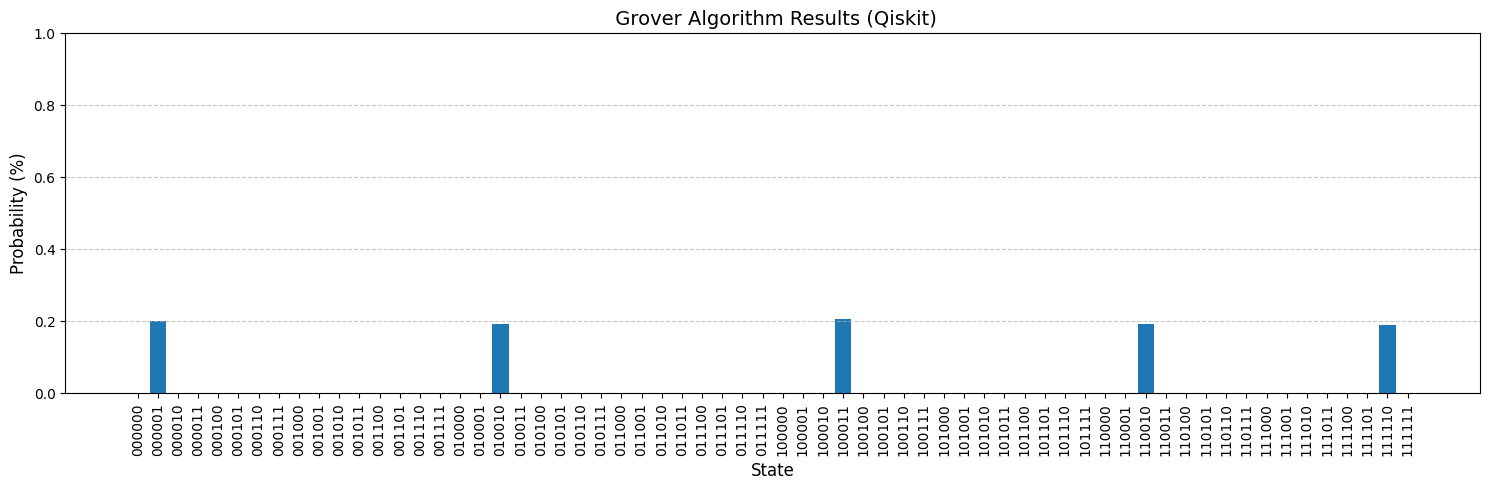

In [26]:
backend_names = {
    'cirq': 'Cirq',
    'qiskit': 'Qiskit',
    'pennylane': 'PennyLane',
    'amazonbraket': 'Amazon Braket',
    'pyquil': 'PyQuil'
}

# ── FRAMEWORK SELECTION MENU ──────────────────────────────────────────────
print("\nSelect a quantum computing framework:")
print("1. Qiskit")
print("2. Cirq")
print("3. PennyLane")
print("4. Amazon Braket")
print("5. PyQuil")

frameworks = {
    '1': 'qiskit',
    '2': 'cirq',
    '3': 'pennylane',
    '4': 'amazonbraket',
    '5': 'pyquil'
}

while True:
    choice = input("\nEnter the number of your choice (1-5): ")
    if choice in frameworks:
        selected_framework = frameworks[choice]
        print(f"\nYou selected: {backend_names[selected_framework]}")
        break
    else:
        print("Invalid option. Please enter a number between 1 and 5.")

# ── MAIN PROGRAM ──────────────────────────────────────────────────────────
translated_circuit = translate_to_framework(circuit, selected_framework)
translated_circuit.print_circuit()

counts_5 = simulate_circuit(circuit, selected_framework)

print("The results of our simulated circuit are:")

if str(selected_framework).lower() == "pyquil":
    counts_5 = simulate_circuit(circuit, selected_framework)          # ya viene en 6 bits
else:
    counts = { state[-6:]: cnt for state, cnt in counts_5.items() } 
    

corrected_counts = {k[::-1]: v for k, v in counts.items()}
print("6-bit counts:", corrected_counts)

total_shots = sum(corrected_counts.values())

probability_counts = {state: cnt / total_shots for state, cnt in corrected_counts.items()}

all_states = [format(i, '06b') for i in range(2**6)]
probs = [probability_counts.get(state, 0) for state in all_states]


import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.bar(all_states, probs)
plt.xlabel('State', fontsize=12)
plt.ylabel('Probability (%)', fontsize=12)
plt.title(f' Grover Algorithm Results ({backend_names[selected_framework]})', fontsize=14)
plt.xticks(rotation='vertical')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()


Select a quantum computing framework:
1. Qiskit
2. Cirq
3. PennyLane
4. Amazon Braket
5. PyQuil



Enter the number of your choice (1-5):  3



You selected: PennyLane
0: ──H──X─╭●──────────────────────╭●──X──X─╭●──────────────────────╭●──X────╭●─────────────────────
1: ──H──X─├●──────────────────────├●──X────├●──────────────────────├●──X────├●─────────────────────
2: ──H──X─│──╭●────────────────╭●─│───X──X─│──╭●────────────────╭●─│───X──X─│──╭●────────────────╭●
3: ──H──X─│──│──╭●──────────╭●─│──│───X──X─│──│──╭●──────────╭●─│──│───X──X─│──│──╭●──────────╭●─│─
4: ──H──X─│──│──│──╭●────╭●─│──│──│───X────│──│──│──╭●────╭●─│──│──│────────│──│──│──╭●────╭●─│──│─
5: ──H────│──│──│──│──╭Z─│──│──│──│───X────│──│──│──│──╭Z─│──│──│──│───X────│──│──│──│──╭Z─│──│──│─
6: ───────╰X─├●─│──│──│──│──│──├●─╰X───────╰X─├●─│──│──│──│──│──├●─╰X───────╰X─├●─│──│──│──│──│──├●
7: ──────────╰X─├●─│──│──│──├●─╰X─────────────╰X─├●─│──│──│──├●─╰X─────────────╰X─├●─│──│──│──├●─╰X
8: ─────────────╰X─├●─│──├●─╰X───────────────────╰X─├●─│──├●─╰X───────────────────╰X─├●─│──├●─╰X───
9: ────────────────╰X─╰●─╰X─────────────────────────╰X─╰●─╰X───────────────

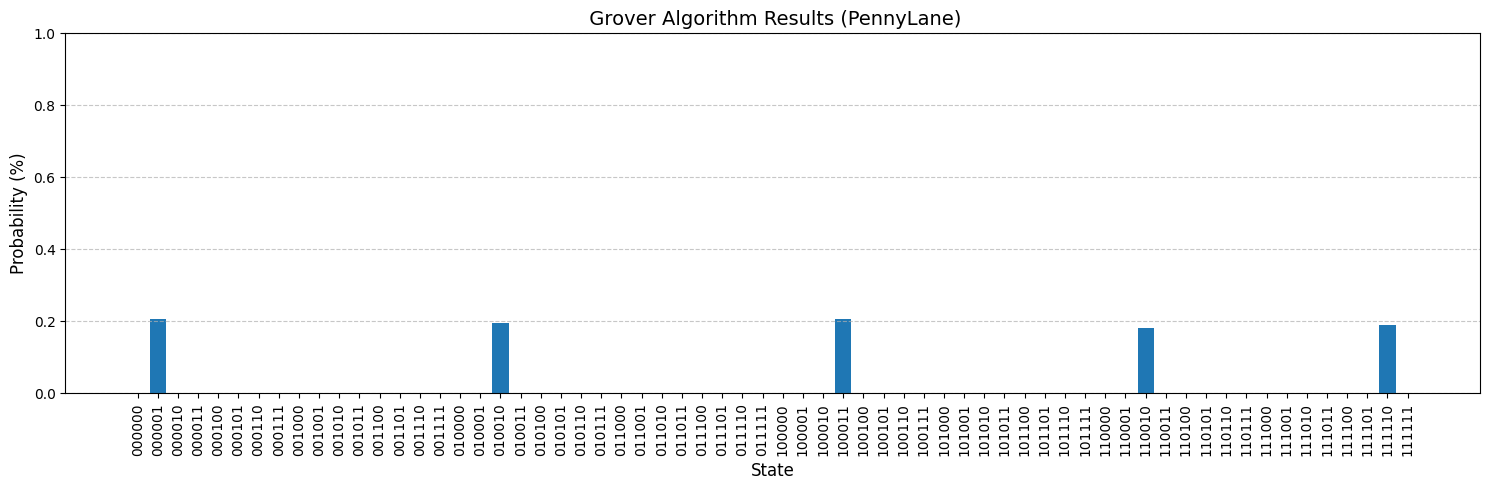

In [27]:
backend_names = {
    'cirq': 'Cirq',
    'qiskit': 'Qiskit',
    'pennylane': 'PennyLane',
    'amazonbraket': 'Amazon Braket',
    'pyquil': 'PyQuil'
}

# ── FRAMEWORK SELECTION MENU ──────────────────────────────────────────────
print("\nSelect a quantum computing framework:")
print("1. Qiskit")
print("2. Cirq")
print("3. PennyLane")
print("4. Amazon Braket")
print("5. PyQuil")

frameworks = {
    '1': 'qiskit',
    '2': 'cirq',
    '3': 'pennylane',
    '4': 'amazonbraket',
    '5': 'pyquil'
}

while True:
    choice = input("\nEnter the number of your choice (1-5): ")
    if choice in frameworks:
        selected_framework = frameworks[choice]
        print(f"\nYou selected: {backend_names[selected_framework]}")
        break
    else:
        print("Invalid option. Please enter a number between 1 and 5.")

# ── MAIN PROGRAM ──────────────────────────────────────────────────────────
translated_circuit = translate_to_framework(circuit, selected_framework)
translated_circuit.print_circuit()

counts_5 = simulate_circuit(circuit, selected_framework)

print("The results of our simulated circuit are:")

if str(selected_framework).lower() == "pyquil":
    counts_5 = simulate_circuit(circuit, selected_framework)          # ya viene en 6 bits
else:
    counts = { state[-6:]: cnt for state, cnt in counts_5.items() } 
    

corrected_counts = {k[::-1]: v for k, v in counts.items()}
print("6-bit counts:", corrected_counts)

total_shots = sum(corrected_counts.values())

probability_counts = {state: cnt / total_shots for state, cnt in corrected_counts.items()}

all_states = [format(i, '06b') for i in range(2**6)]
probs = [probability_counts.get(state, 0) for state in all_states]


import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.bar(all_states, probs)
plt.xlabel('State', fontsize=12)
plt.ylabel('Probability (%)', fontsize=12)
plt.title(f' Grover Algorithm Results ({backend_names[selected_framework]})', fontsize=14)
plt.xticks(rotation='vertical')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()


Select a quantum computing framework:
1. Qiskit
2. Cirq
3. PennyLane
4. Amazon Braket
5. PyQuil



Enter the number of your choice (1-5):  3



You selected: PennyLane
0: ──H──X─╭●──────────────────────╭●──X──X─╭●──────────────────────╭●──X────╭●─────────────────────
1: ──H──X─├●──────────────────────├●──X────├●──────────────────────├●──X────├●─────────────────────
2: ──H──X─│──╭●────────────────╭●─│───X──X─│──╭●────────────────╭●─│───X──X─│──╭●────────────────╭●
3: ──H──X─│──│──╭●──────────╭●─│──│───X──X─│──│──╭●──────────╭●─│──│───X──X─│──│──╭●──────────╭●─│─
4: ──H──X─│──│──│──╭●────╭●─│──│──│───X────│──│──│──╭●────╭●─│──│──│────────│──│──│──╭●────╭●─│──│─
5: ──H────│──│──│──│──╭Z─│──│──│──│───X────│──│──│──│──╭Z─│──│──│──│───X────│──│──│──│──╭Z─│──│──│─
6: ───────╰X─├●─│──│──│──│──│──├●─╰X───────╰X─├●─│──│──│──│──│──├●─╰X───────╰X─├●─│──│──│──│──│──├●
7: ──────────╰X─├●─│──│──│──├●─╰X─────────────╰X─├●─│──│──│──├●─╰X─────────────╰X─├●─│──│──│──├●─╰X
8: ─────────────╰X─├●─│──├●─╰X───────────────────╰X─├●─│──├●─╰X───────────────────╰X─├●─│──├●─╰X───
9: ────────────────╰X─╰●─╰X─────────────────────────╰X─╰●─╰X───────────────

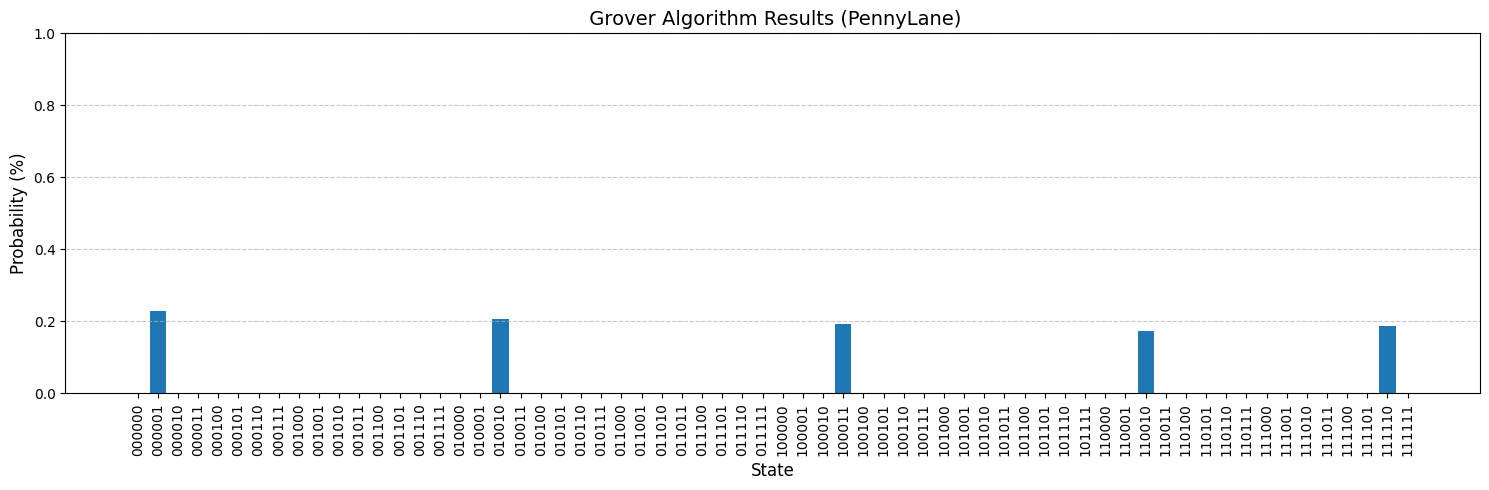

In [28]:
backend_names = {
    'cirq': 'Cirq',
    'qiskit': 'Qiskit',
    'pennylane': 'PennyLane',
    'amazonbraket': 'Amazon Braket',
    'pyquil': 'PyQuil'
}

# ── FRAMEWORK SELECTION MENU ──────────────────────────────────────────────
print("\nSelect a quantum computing framework:")
print("1. Qiskit")
print("2. Cirq")
print("3. PennyLane")
print("4. Amazon Braket")
print("5. PyQuil")

frameworks = {
    '1': 'qiskit',
    '2': 'cirq',
    '3': 'pennylane',
    '4': 'amazonbraket',
    '5': 'pyquil'
}

while True:
    choice = input("\nEnter the number of your choice (1-5): ")
    if choice in frameworks:
        selected_framework = frameworks[choice]
        print(f"\nYou selected: {backend_names[selected_framework]}")
        break
    else:
        print("Invalid option. Please enter a number between 1 and 5.")

# ── MAIN PROGRAM ──────────────────────────────────────────────────────────
translated_circuit = translate_to_framework(circuit, selected_framework)
translated_circuit.print_circuit()

counts_5 = simulate_circuit(circuit, selected_framework)

print("The results of our simulated circuit are:")

if str(selected_framework).lower() == "pyquil":
    counts_5 = simulate_circuit(circuit, selected_framework)          # ya viene en 6 bits
else:
    counts = { state[-6:]: cnt for state, cnt in counts_5.items() } 
    

corrected_counts = {k[::-1]: v for k, v in counts.items()}
print("6-bit counts:", corrected_counts)

total_shots = sum(corrected_counts.values())

probability_counts = {state: cnt / total_shots for state, cnt in corrected_counts.items()}

all_states = [format(i, '06b') for i in range(2**6)]
probs = [probability_counts.get(state, 0) for state in all_states]


import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.bar(all_states, probs)
plt.xlabel('State', fontsize=12)
plt.ylabel('Probability (%)', fontsize=12)
plt.title(f' Grover Algorithm Results ({backend_names[selected_framework]})', fontsize=14)
plt.xticks(rotation='vertical')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()

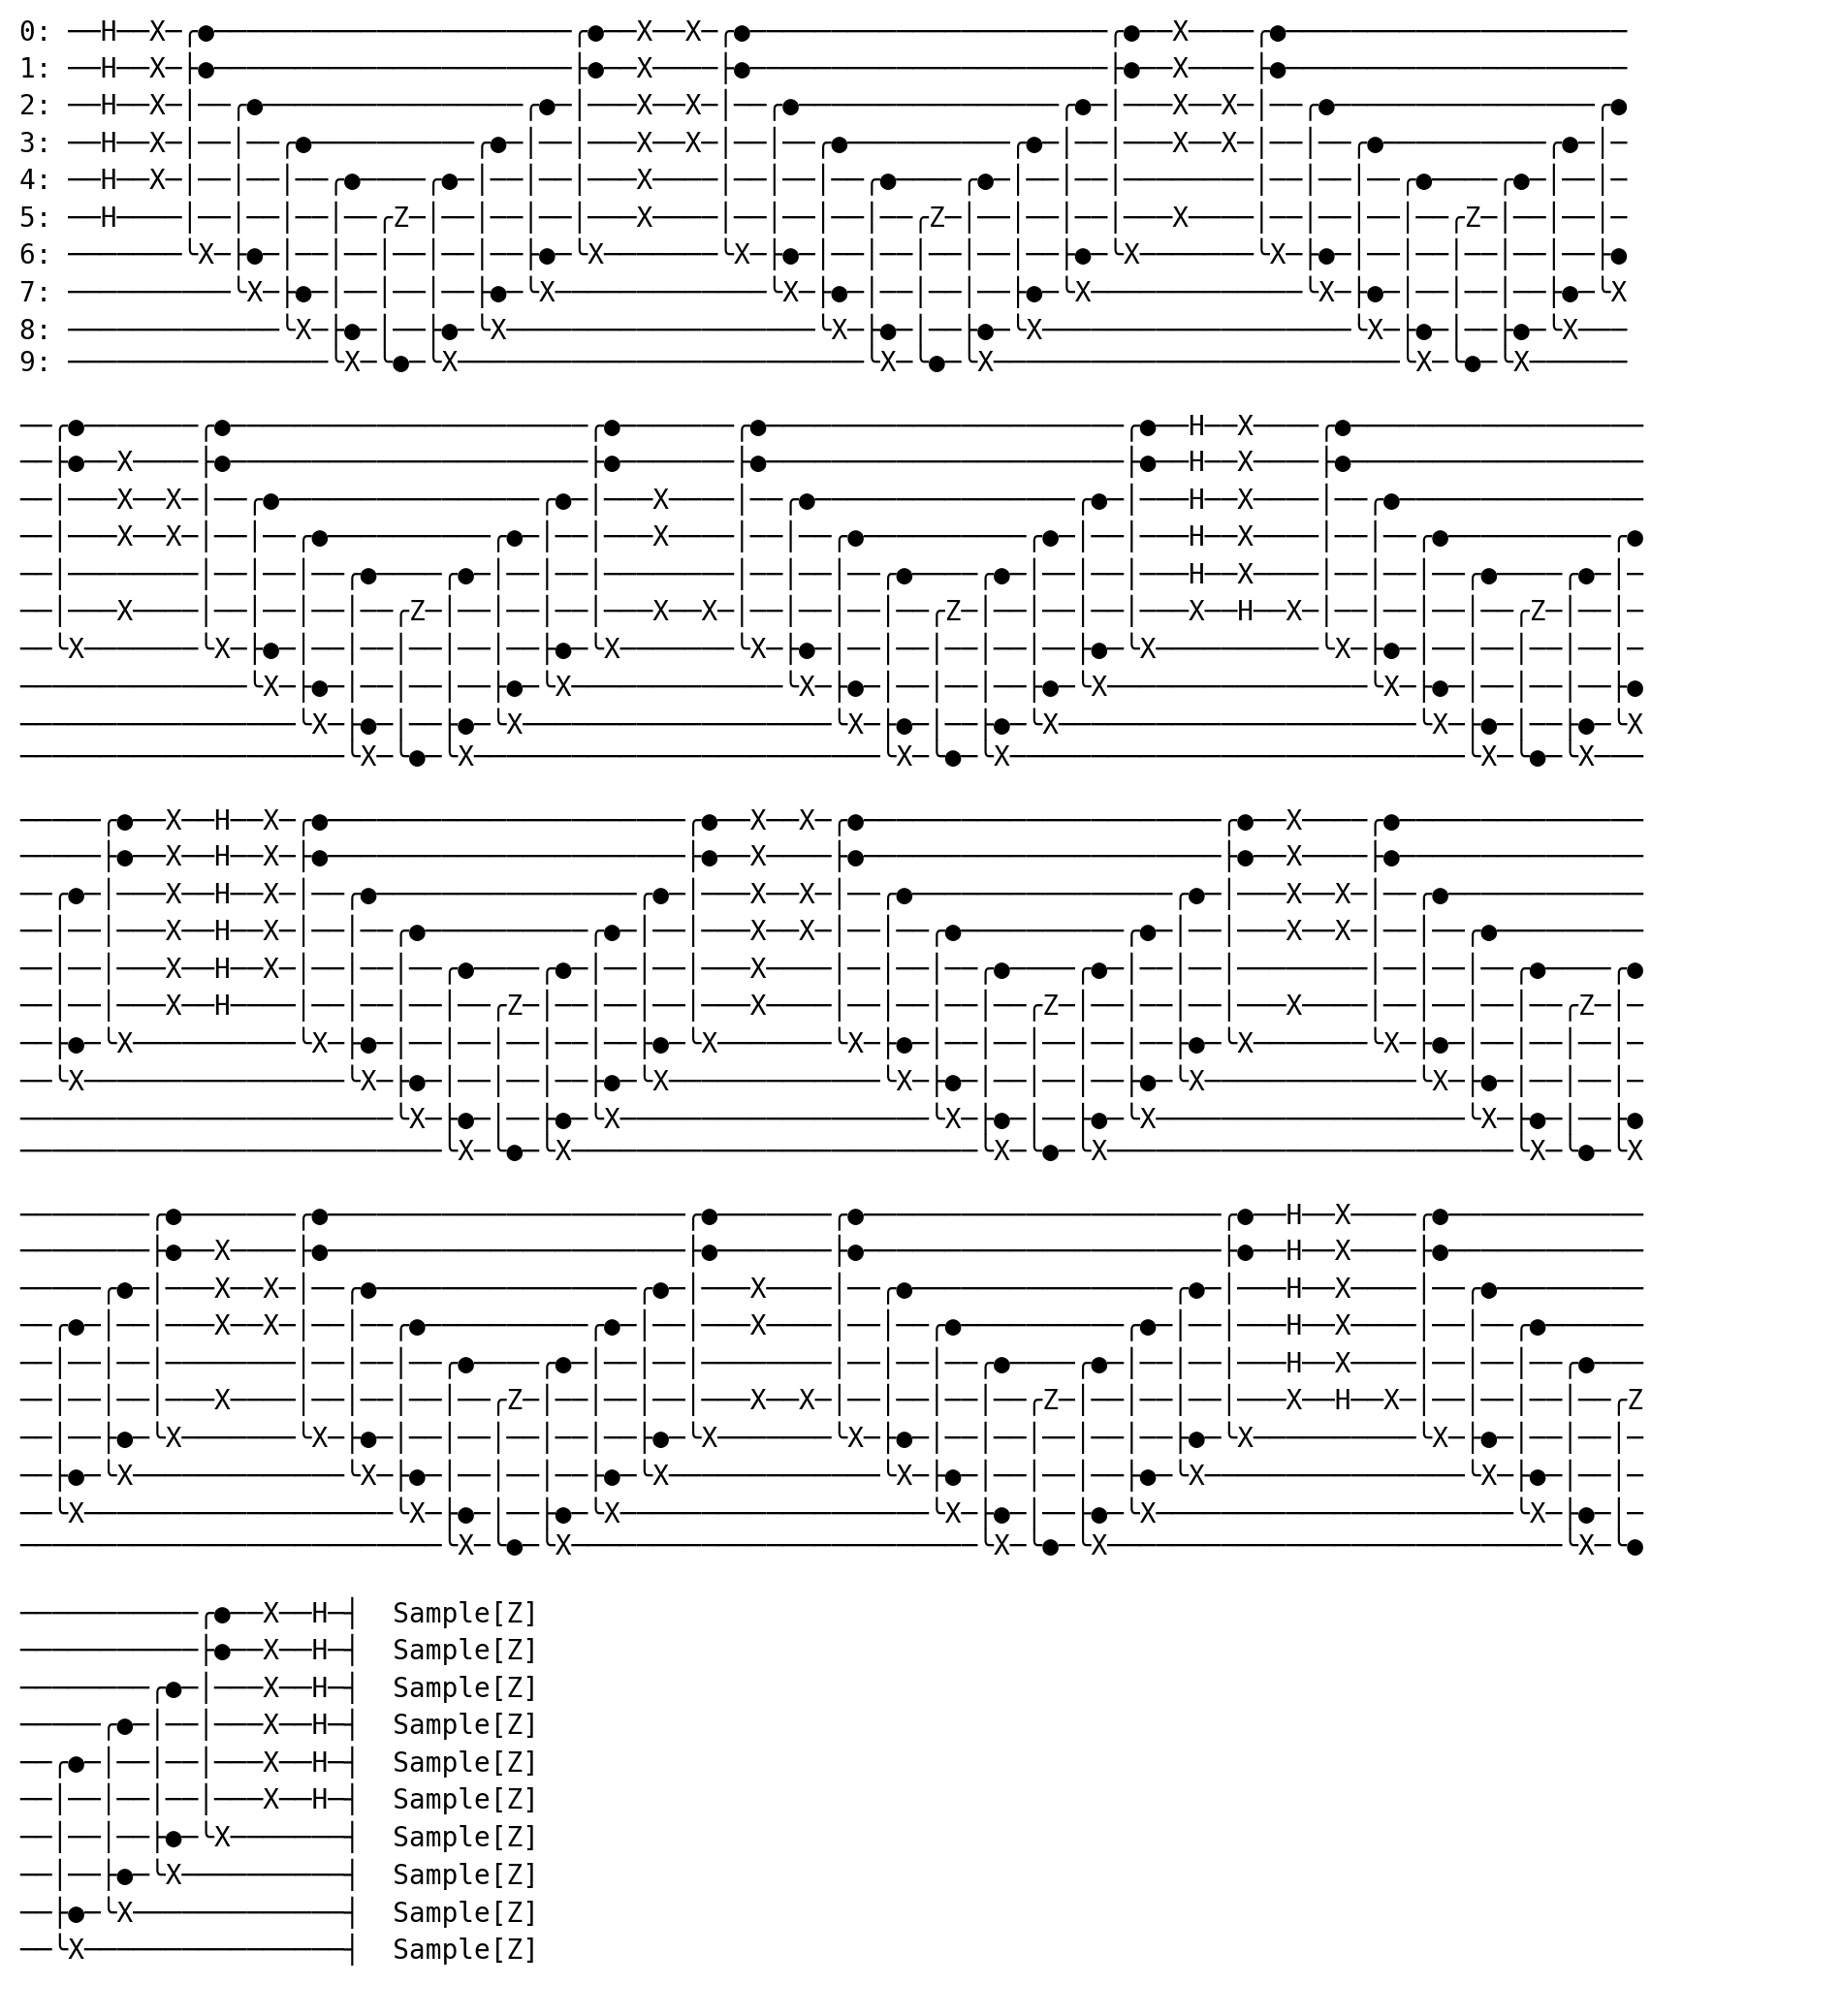

In [45]:
# The following is to save the circuit of each platform in an image
import matplotlib.pyplot as plt
import io
import sys

# Redirect stdout to capture circuit text
stdout = sys.stdout
sys.stdout = io.StringIO()

selected_framework = 'pennylane'  # Change this to the desired framework
translated_circuit = translate_to_framework(circuit, selected_framework)
translated_circuit.print_circuit()

printed_circuit = sys.stdout.getvalue()
sys.stdout = stdout

# Split lines to estimate size
lines = printed_circuit.split("\n")
max_line_length = max(len(line) for line in lines)
num_lines = len(lines)

# Auto-adjust figure size based on text
fig_width = max_line_length * 0.12
fig_height = num_lines * 0.22

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=200)
ax.text(0, 1, printed_circuit,
        ha='left', va='top',
        family='monospace', fontsize=10,
        transform=ax.transAxes)


ax.axis('off')

# Save the figure with all extra space removed
plt.savefig("Fig5a.eps",
            dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()

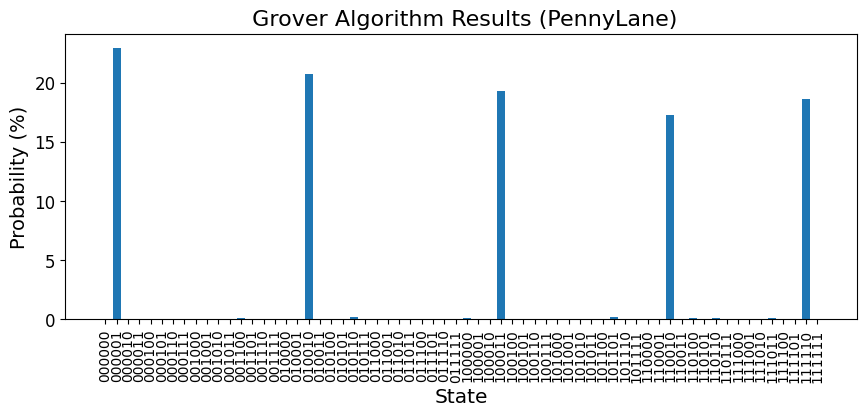

In [46]:
# the following code is to save the image from the histogram

# Convert counts to percentages
total_shots = sum(corrected_counts.values())
probability_counts = {state: cnt / total_shots for state, cnt in corrected_counts.items()}

# Define all possible 3-qubit states (000000, 001000, 010000, ..., 111111) to show on the histogram
all_states = [format(i, '06b') for i in range(2**6)]
probs = [probability_counts.get(state, 0) * 100 for state in all_states]  # multiply by 100

import matplotlib.pyplot as plt

# Create a narrower and taller figure
plt.figure(figsize=(8.5, 4))  # width=6, height=4 (adjust if needed)
# Create the bar plot
plt.bar(all_states, probs, width=0.70)
# Labels with larger fonts
plt.xlabel('State', fontsize=14.5)
plt.ylabel('Probability (%)', fontsize=14)
plt.title(f' Grover Algorithm Results ({backend_names[selected_framework]})', fontsize=16)
# More readable ticks
plt.xticks(rotation='vertical', fontsize=10)
plt.yticks(fontsize=12)

#plt.tick_params(axis="x", pad=6)  
#plt.ylim(0, 1)
plt.tight_layout(pad=0.1)
# Save adjusted image
plt.savefig("Fig5b.eps",dpi=300, bbox_inches='tight', pad_inches=0.05)
# Show the histogram
plt.show()